<a href="https://colab.research.google.com/github/glaserlab/LVM-Workshop/blob/main/nb2_LDS_PLDS_SLDS_sols.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import Packages**

In [1]:
import numpy as np
import matplotlib.pyplot as plt

#Some helper functions for Gaussians
from numpy.random import normal, multivariate_normal
from scipy.stats import norm

#Some scikit learn models we'll be using
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA,FactorAnalysis

#To load the data file
import pickle

## 1) Linear dynamical systems (Kalman filters)

We'll be using the ssm package for fitting linear dynamical systems. Run the code below to install that package.

In [2]:
!pip install git+https://github.com/lindermanlab/ssm.git@master#egg=ssm

import ssm

  Cloning https://github.com/lindermanlab/ssm.git (to revision master) to /tmp/pip-install-fdcuz1dg/ssm_daf2f7a7f85d4a2b9e0afd79ae6a6dcd
  Running command git clone --filter=blob:none --quiet https://github.com/lindermanlab/ssm.git /tmp/pip-install-fdcuz1dg/ssm_daf2f7a7f85d4a2b9e0afd79ae6a6dcd
  Resolved https://github.com/lindermanlab/ssm.git to commit eb6c8aa33e5311d3564075807dec340759dd8081
  Preparing metadata (setup.py) ... done
  Created wheel for ssm: filename=ssm-0.0.1-cp312-cp312-linux_x86_64.whl size=614375 sha256=1ff0521c5e12ca9674a5cdf71a317a188c6c15af1ae79410c0bbbc3dd45e4c2f
  Stored in directory: /tmp/pip-ephem-wheel-cache-95wmhogh/wheels/c9/65/dd/08f353690a989c939ae40c1b3f21893af69b960b08b7facb4d
Successfully built ssm


A) Fill in the code below to simulate data from a linear dynamical system model with 2-dimensional latents, and 5-dimensional observations.

<br>
The dynamics matrix is the scaled rotation matrix (which will cause the latents to spiral) :<br>
$A = \begin{bmatrix} cos(\theta) & -sin(\theta) \\ sin(\theta) & cos(\theta) \end{bmatrix} \text{for  } \theta=\pi/20$

<br><br>
In the code below, the emissions (observations) matrix is random, and there is more noise in the observations than the dynamics (see code below).


In [3]:
np.random.seed(0)

#Dimensionality of latents
K=2
#Dimensionality of observations
N=5

#Initial latent state
Z0=np.array([.5,.5])

#Dynamics matrix
th=np.pi/20
A = .995 * np.array([[np.cos(th),-np.sin(th)],[np.sin(th),np.cos(th)]])

#Noise of dynamics
Sig_dynamics=.0001*np.identity(K)

#Emissions (observations) matrix
C=np.random.randn(K,N)

#Noise of observations
Sig_observations=.01*np.identity(N)

#Number of time points to simulate for
T=500

#Initialize latents and observations
Z = np.zeros((T,K))
Y = np.zeros((T,N))

#Set initial state (at time 0) of the latents
Z[0]=Z0

#Update observations at time 0 according to the latent state
Y[0]=Z[0]@C+multivariate_normal(np.zeros(N),Sig_observations)

# Loop over time points
# At each time point, sample the next latent state (based on the dynamics matrix and the previous state),
# and then determine the observation at that time point
for t in range(1,T):
  #Update latent state at time t according to dynamics
  Z[t]=A@Z[t-1]+multivariate_normal(np.zeros(K),Sig_dynamics)

  #Update observations at time t according to the latent state
  Y[t]=Z[t]@C+multivariate_normal(np.zeros(N),Sig_observations)

Run the code below to plot the two dimensions of the latent against each other (to see the spiral if the above simulation is correct)

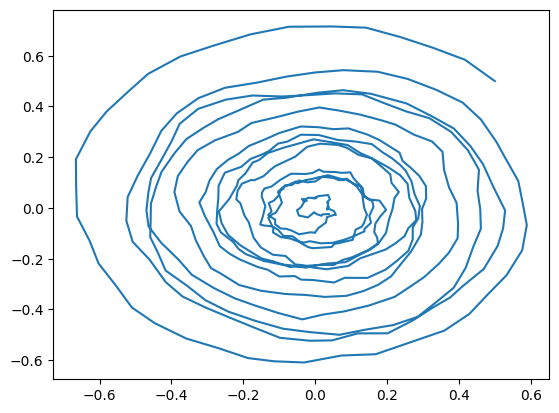

In [4]:
plt.plot(Z[:,0],Z[:,1])

Run the code below to plot the two dimensions of the latent as a function of time

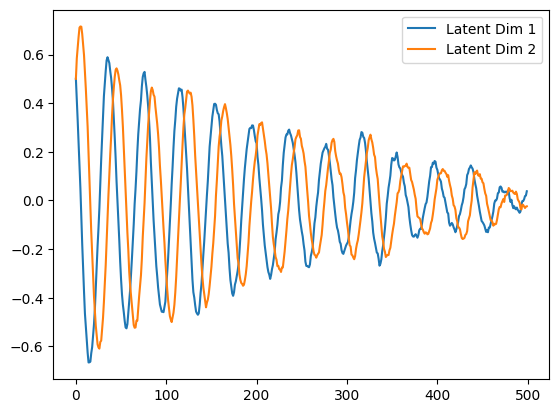

In [5]:
plt.plot(Z[:,0])
plt.plot(Z[:,1])
plt.legend(['Latent Dim 1','Latent Dim 2'])

Run the code below to plot the first two dimensions of the observations as a function of time

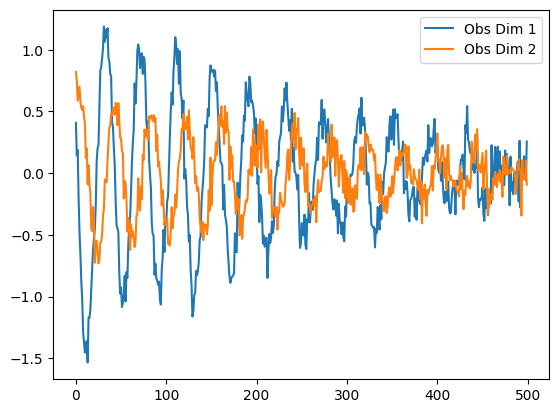

In [6]:
plt.plot(Y[:,0])
plt.plot(Y[:,1])
plt.legend(['Obs Dim 1','Obs Dim 2'])

B) Fit a factor analysis model (using sci-kit learn) with 2 latents to the above observations

In [7]:
fa=FactorAnalysis(2)
z_fa=fa.fit_transform(Y)

C) Plot the 2 factor analysis latents as a function of time

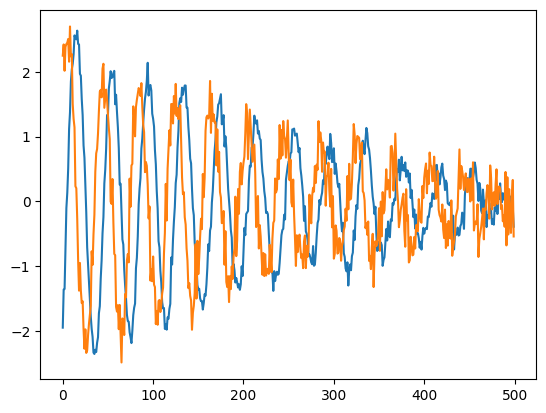

In [8]:
plt.plot(z_fa)

D) Fit an LDS model to the data

You can run the ssm code below (no need to make any changes). Still, read through the code/comments to try to generally understand the below code.

In [9]:
obs_dim=N
latent_dim=K

#Define an LDS model that has a Gaussian emissions model, with the correct latent and observation dimensions
lds = ssm.LDS(obs_dim, latent_dim, emissions="gaussian")

#Fit the LDS model using EM
#Note the method says 'laplace_em', which becomes standard EM with Gaussian emissions
elbos, q = lds.fit(Y, method="laplace_em", num_iters=10)

#The output q contains the posterior distribution (the latent's mean and variance)
#Below, we'll just extract the mean of the posterior at each time point (the value we usually think of as the latent):
z_lds = q.mean_continuous_states[0]

  0%|          | 0/1 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

E) Plot the latents learned by LDS

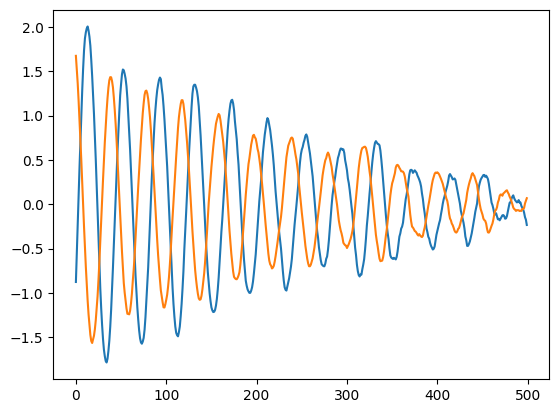

In [10]:
plt.plot(z_lds)

F) How do the learned latents differ between the factor analysis and LDS models? Why?  (Enter your answer in the text box below)

The learned latents from the LDS model are substantially smoother (and more closely resemble the true underlying latents). This is because the LDS model incorporates a model of the dynamics, unlike factor analysis. The latents in an LDS model (occurring via a Kalman filter or smoother) are estimated by incorporating both learned dynamics in the latent space, and having an accurate mapping to the high-dimensional observations (which is what FA analysis only cares about).

G) Run the below code to check that the eigenvalues of the system's dynamics (the A matrix) were recovered correctly. Note that the eigenvectors, and the A matrices themselves won't be identical, because the emissions matrix can be recovered differently from the ground truth (e.g. some linear combination of the ground truth).

In [11]:
#Eigendecomposition of true dynamics
np.linalg.eig(A)

EigResult(eigenvalues=array([0.9827499+0.15565229j, 0.9827499-0.15565229j]), eigenvectors=array([[0.        +0.70710678j, 0.        -0.70710678j],
       [0.70710678+0.j        , 0.70710678-0.j        ]]))

In [12]:
#Eigendecomposition of learned dynamics
np.linalg.eig(lds.dynamics.As)

EigResult(eigenvalues=array([[0.97986626+0.154631j, 0.97986626-0.154631j]]), eigenvectors=array([[[ 0.77392509+0.j        ,  0.77392509-0.j        ],
        [-0.44042175+0.45504796j, -0.44042175-0.45504796j]]]))

## 2) Linear Dynamical Systems on Neural Data



Now we're going to fit an LDS to some real neural data. This is data collected in Lee Miller's lab from motor cortex while a monkey continues to reach to targets across a workspace.
Within a trial, a monkey typically makes 4 reaches (although occasionally less if he makes an error and the trial ends early). After the 4 reaches there is a brief pause while the monkey gets a juice reward. All trials are concatenated together in time in the data. <br>

"Neural data" is a variable of size Timepoints x Neurons, where each entry is the firing rate of a given neuron in that time bin. <br>
"Velocity" is a variable of size Timepoints x 2, where each timepoint has the x and y velocities of the hand.

Each time bin, of both neural activity and velocity, is duration 50ms.

In [13]:
#Download and load the data

!wget -nc https://www.dropbox.com/s/jcief15oql3tkll/example_data_m1.pickle?dl=0

filename    = 'example_data_m1.pickle?dl=0'
with open(filename, 'rb') as handle:
    [Neural_data_tmp,Velocity_tmp] = pickle.load(handle)

--2025-10-14 19:54:31--  https://www.dropbox.com/s/jcief15oql3tkll/example_data_m1.pickle?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:6017:18::a27d:212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/a3z0kyr1yofqysk1oohaq/example_data_m1.pickle?rlkey=q1wz28fivxzthatok9d01arve&dl=0 [following]
--2025-10-14 19:54:32--  https://www.dropbox.com/scl/fi/a3z0kyr1yofqysk1oohaq/example_data_m1.pickle?rlkey=q1wz28fivxzthatok9d01arve&dl=0
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc0c95c232bf5a85af350abc50bc.dl.dropboxusercontent.com/cd/0/inline/CzM4jU_Z8QKX8wwMFGn8VT2a9vqzxC2GLlSFY7pksCdu4RBGxRfX28tQnKaBba2RdRhnHd2pjTWveq5qcDgA-Ugu6O9VqvKZymqAYAXbFAgRz6OqOEzJmuYSEkEPt9k58xU/file# [following]
--2025-10-14 19:54:32--  https://uc0c95c232bf5a85af350abc50bc.dl.dropboxuserc

We're just going to extract the first 1000 time points for this assignment, so that the models fit faster.

In [14]:
Neural_data=Neural_data_tmp[:1000,:]
Velocity=Velocity_tmp[:1000,:]

A) Fit a Factor Analysis model to the Neural data with 10 latents

In [15]:
fa=FactorAnalysis(10)
continuous_latents_fa=fa.fit_transform(Neural_data)

B) Fit a linear dynamical systems model to the neural data with 10 latents. Note that this will take around 30+ seconds to fit. You can just run the code below.

In [16]:
np.random.seed(0)

obs_dim=Neural_data.shape[1]
latent_dim=10

#Declare the LDS model
lds = ssm.LDS(obs_dim, latent_dim, emissions="gaussian")

#Fit the LDS model
elbos, q = lds.fit(Neural_data, method="laplace_em", num_iters=10)

#Get the latents:
continuous_latents_lds = q.mean_continuous_states[0]

  0%|          | 0/1 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

C) Run the code below to plot the first two FA and LDS latents for a brief snippet of time (200 time bins = 10 sec)

Text(0.5, 1.0, 'LDS latents')

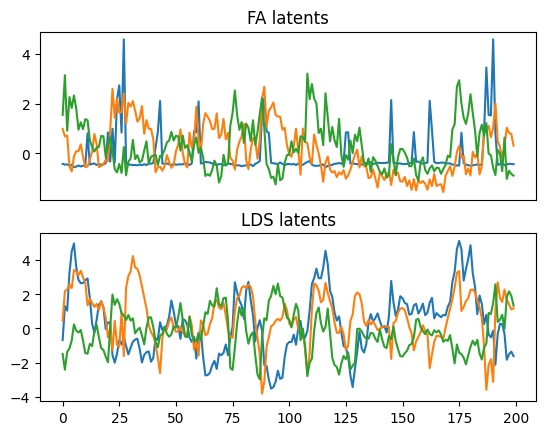

In [17]:
plt.figure()

plt.subplot(2,1,1)
plt.plot(continuous_latents_fa[:200,:3])
plt.title('FA latents')
plt.xticks([])

plt.subplot(2,1,2)
plt.plot(continuous_latents_lds[:200,:3])
plt.title('LDS latents')


D) At least to me, unlike the simulation example above, it's not obvious in the above plots that the LDS model has smoother latents. In the text box below, why do you think LDS doesn't lead to such smooth responses here. (Hint: There are realistically multiple reasons, but I'm mainly looking for whether LDS is a good model for this data, which contains an entire experiment concatenated together).

Linear dynamics are often a reasonable approximation within a limited time where a given behavior is happening - for example just during reach, or just during the preparation time. Linear dynamics will not be such a good approximation on data that is concatenated across delay periods, movement periods, intertrial periods, etc.

E) Still, let's quantitatively see how 'relatively smooth' the latents are. For each latent, we'll calculate the squared change in the latent at each time point, relative to the average squared magnitude of the latent. A smaller value will mean it's smoother (changing less from one time point to the next). We will then plot a histogram of this relative change. Run the below code cells

In [18]:
z=np.copy(continuous_latents_fa)
relative_change_fa=[np.mean((z[1:,l]-z[:-1,l])**2)/np.mean(z[:,l]**2) for l in range(latent_dim)]
print(relative_change_fa)

[np.float64(0.9268308147094099), np.float64(0.31519297317905093), np.float64(0.40783973522164463), np.float64(0.6473556347113493), np.float64(0.560321503978107), np.float64(0.859534078440912), np.float64(0.9056872967698167), np.float64(0.9582738715313904), np.float64(1.0202798774961601), np.float64(1.1797057824367294)]


In [19]:
z=np.copy(continuous_latents_lds)
relative_change_lds=[np.mean((z[1:,l]-z[:-1,l])**2)/np.mean(z[:,l]**2) for l in range(latent_dim)]
print(relative_change_lds)

[np.float64(0.20443462073239504), np.float64(0.32305876733277933), np.float64(0.2583152993690606), np.float64(0.18188338073512192), np.float64(0.46160006537025294), np.float64(0.6960296012821949), np.float64(0.16409825503766387), np.float64(0.2767495260213325), np.float64(0.4122740692451179), np.float64(0.4119041606200482)]


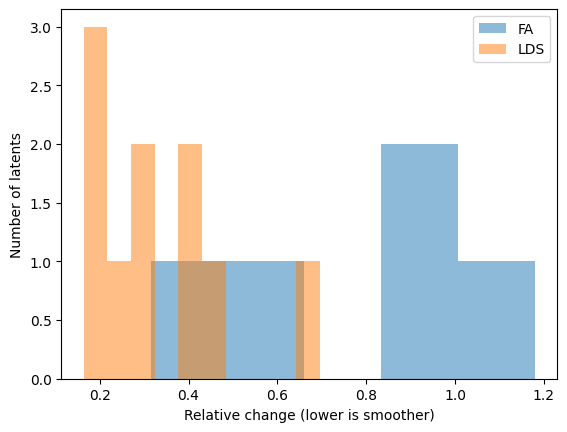

In [20]:
plt.hist(relative_change_fa,alpha=0.5)
plt.hist(relative_change_lds,alpha=0.5)
plt.xlabel('Relative change (lower is smoother)')
plt.ylabel('Number of latents')

plt.legend(['FA','LDS'])

F) Does LDS lead to smoother latents (Yes or No)? Answer in the text box below.

Yes

G) One way to validate that we are getting a better estimate of the underlying latents is to try to see which set of latents best relates to a separate, external variable (here, velocity).

Fit decoding models from 1) the Factor analysis latents to velocity, and 2) the LDS latents to velocity, and see which leads to better performance.

In the decoding models, use latents that precede the velocity by 2 time bins (100 ms). That is, use Latents[:-2] to predict Velocity[2:]. This will improve decoding performance, since there is a lag for motor cortical signals to be maximally predictive of movement velocity.

For the sake of time, you can do this is a non-rigorous (non-cross-validated way). Just report the "score" (R2 value) from two sci-kit learn linear regression models, where you train on all of the data.

In [21]:
#Fit linear regression model based on factor analysis latents
lr_fa=LinearRegression()
lr_fa.fit(continuous_latents_fa[:-2],Velocity[2:])
lr_fa.score(continuous_latents_fa[:-2],Velocity[2:])

0.4873635557257251

In [22]:
#Fit linear regression model based on LDS latents
lr_lds=LinearRegression()
lr_lds.fit(continuous_latents_lds[:-2],Velocity[2:])
lr_lds.score(continuous_latents_lds[:-2],Velocity[2:])

0.5941385007878139

### PLDS Models

G) Now we'll fit a Poisson Linear Dynamical system to the data. You can just run the code below.

In [23]:
np.random.seed(1)

obs_dim=Neural_data.shape[1]
latent_dim=10

#Declare the PLDS model
lds = ssm.LDS(obs_dim, latent_dim, emissions="poisson", emission_kwargs=dict(link="softplus"))

#Fit the PLDS model
elbos, q = lds.fit(Neural_data.astype(int), method="laplace_em", num_iters=10)

#Get the latents:
continuous_latents_plds = q.mean_continuous_states[0]

  0%|          | 0/1 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Plot the ELBO over model iterations to check that the model has converged. You can just run the code below.

Text(0, 0.5, 'ELBO')

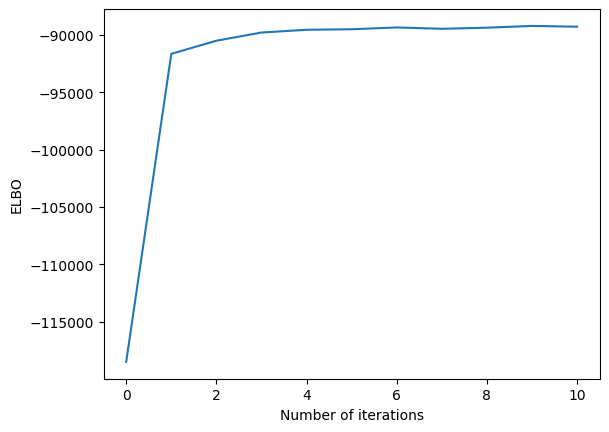

In [24]:
plt.plot(elbos)
plt.xlabel('Number of iterations')
plt.ylabel('ELBO')

H) Decode velocity based on the PLDS latents (again, with a lag of 2 time bins), in order to see how this compares to the LDS latents. Report the "score" (R2 value). Note that the value will be approximately the same here as what you got for LDS - when fitting the LDS/PLDS model with many more data points, a small difference starts to emerge. Note that a likely reason for the limited difference is the large time bins (50ms), and when there are many spikes within a time bin, a Gaussian approximation to a Poisson distribution is reasonable.

In [25]:
#Fit linear regression model based on PLDS latents
lr_plds=LinearRegression()
lr_plds.fit(continuous_latents_plds[:-2],Velocity[2:])
lr_plds.score(continuous_latents_plds[:-2],Velocity[2:])

0.5976700499083463

I) Plot the first 3 latents found with PLDS relative to LDS. To do so, fill in the code below.

Text(0.5, 1.0, 'LDS latents')

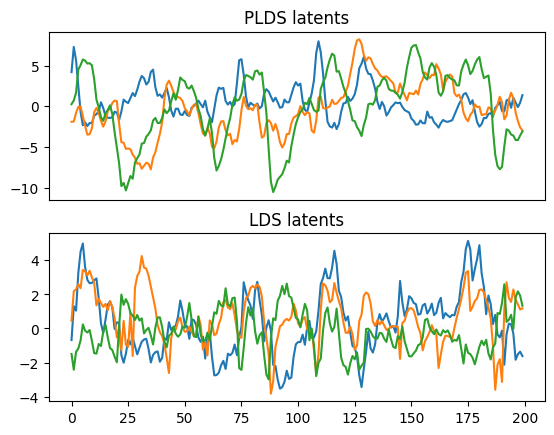

In [26]:
plt.figure()

plt.subplot(2,1,1)
plt.plot(continuous_latents_plds[:200,:3])
plt.title('PLDS latents')
plt.xticks([])

plt.subplot(2,1,2)
plt.plot(continuous_latents_lds[:200,:3])
plt.title('LDS latents')

J) Quantitatively determine how the relative smoothness of the latents found with PLDS compare to that of LDS. Create a histogram of the "relative change" of each latent for LDS and PLDS (you can mostly copy the code from above when you compared FA and LDS).

In [27]:
z=np.copy(continuous_latents_plds)
relative_change_plds=[np.mean((z[1:,l]-z[:-1,l])**2)/np.mean(z[:,l]**2) for l in range(10)]

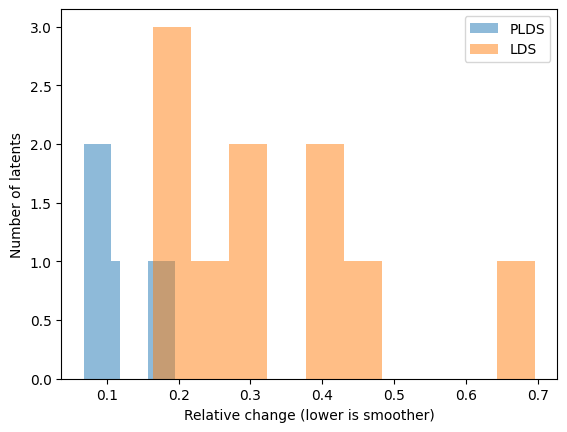

In [28]:
plt.hist(relative_change_plds,alpha=0.5)
plt.hist(relative_change_lds,alpha=0.5)
plt.xlabel('Relative change (lower is smoother)')
plt.ylabel('Number of latents')

plt.legend(['PLDS','LDS'])

### SLDS models

K) Run an SLDS model with 2 discrete states, with a Poisson emissions model. You can just run the code below.

In [29]:
np.random.seed(1)

obs_dim=Neural_data.shape[1]
discrete_dim=2
latent_dim=10

#Declare the SLDS model
slds2 = ssm.SLDS(obs_dim, discrete_dim, latent_dim, emissions="poisson", emission_kwargs=dict(link="softplus"))

#Fit the SLDS model
slds2_elbos, q_lem = slds2.fit(Neural_data.astype(int), method="laplace_em",
                               variational_posterior="structured_meanfield",
                               num_iters=20, alpha=0.0)
#Get the latents:
continuous_latents_slds = q_lem.mean_continuous_states[0]

  0%|          | 0/1 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

L) Plot the ELBO over iterations, so you can get an idea that the model has converged. You can just run the code below.

Text(0, 0.5, 'ELBO')

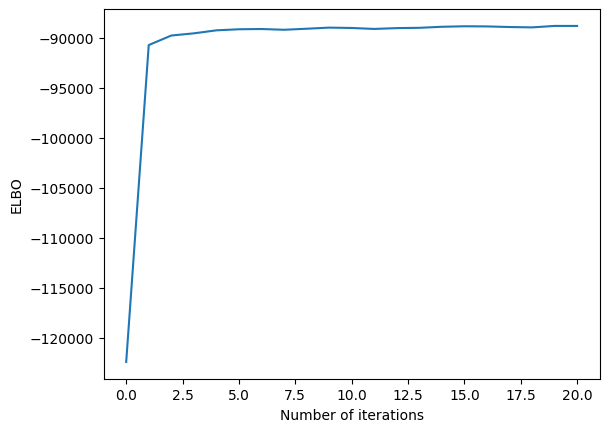

In [30]:
plt.plot(slds2_elbos)
plt.xlabel('Number of iterations')
plt.ylabel('ELBO')

Text(0, 0.5, 'ELBO')

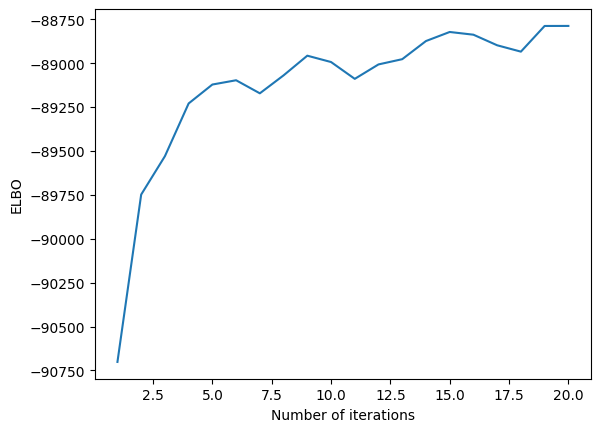

In [31]:
plt.plot(np.arange(1,20.1),slds2_elbos[1:])
plt.xlabel('Number of iterations')
plt.ylabel('ELBO')

M) Decode velocity based on the SLDS latents, in order to see how this compares to the previous LDS/PLDS latents (again with a lag of 2 time bins). Report the "score" (R2 value)

In [32]:
#Fit linear regression model based on SLDS latents
lr_slds=LinearRegression()
lr_slds.fit(continuous_latents_slds[:-2],Velocity[2:])
lr_slds.score(continuous_latents_slds[:-2],Velocity[2:])

0.6187571515933893

N) Run the code below to get the most likely states of the SLDS model, and plot them. We will plot the states over the behavioral velocity traces.

In [33]:
discrete_latents_slds = slds2.most_likely_states(continuous_latents_slds, Neural_data.astype(int))

(0.0, 1000.0)

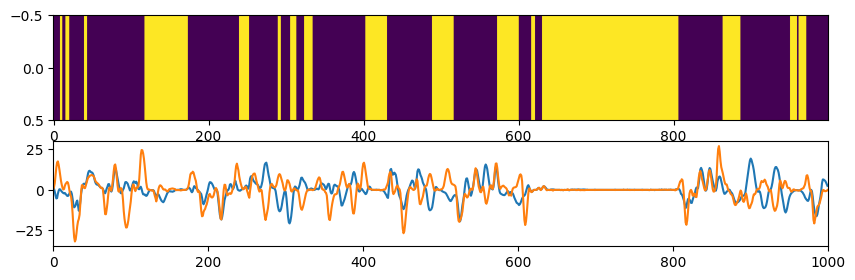

In [34]:
plt.figure(figsize=(10,3))
plt.subplot(2,1,1)
plt.imshow(discrete_latents_slds[None,:1000],aspect='auto')
plt.subplot(2,1,2)
plt.plot(Velocity[:1000])
plt.xlim([0,1000])

O) In the text box below, write what behaviors the discrete states seem to belong to.

For the most part, times of 1) movement and 2) non-movement (or limited movement)

P) Fit an SLDS model with 3 discrete states.

In [35]:
np.random.seed(1)

obs_dim=Neural_data.shape[1]
discrete_dim=3
latent_dim=10

#Declare the LDS model
slds3 = ssm.SLDS(obs_dim, discrete_dim, latent_dim, emissions="poisson", emission_kwargs=dict(link="softplus"))

#Fit the LDS model
slds3_elbos, q_lem = slds3.fit(Neural_data.astype(int), method="laplace_em",
                               variational_posterior="structured_meanfield",
                               num_iters=20, alpha=0.0)
#Get the latents:
continuous_latents_slds = q_lem.mean_continuous_states[0]

  0%|          | 0/1 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Q) Plot the most likely discrete states on top of the velocity traces, as before.

In [36]:
discrete_latents_slds = slds3.most_likely_states(continuous_latents_slds, Neural_data.astype(int))

(0.0, 1000.0)

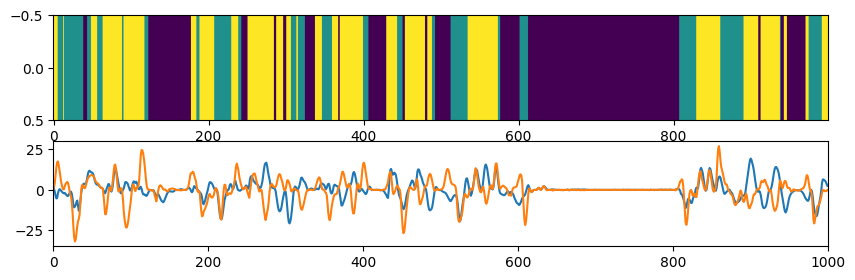

In [37]:
plt.figure(figsize=(10,3))
plt.subplot(2,1,1)
plt.imshow(discrete_latents_slds[None,:1000],aspect='auto')
plt.subplot(2,1,2)
plt.plot(Velocity[:1000])
plt.xlim([0,1000])

R) Is it clear what the 3 states relate to? Enter in the text box below.

One state relates to non-movement. The other two states is less clear - there's possibly a difference based on reach direction (the green state typically occurs when the orange velocity trace becomes negative, which would correspond to moving downwards since orange is the y-direction velocity).

S) Which SLDS model (the one with 2 or 3 discrete states) had a better fit to the training data, in terms of their ELBO. Print out the elbo value on the final iteration for the two models (this will be the last entry in 'slds2_elbos', for example), and then in the text box, state which is higher.

In [38]:
print('2 state training elbo:', slds2_elbos[-1])
print('3 state training elbo:', slds3_elbos[-1])

2 state training elbo: -88787.51023307968
3 state training elbo: -88773.16447795027


In this example, the 3 state training elbo is higher than the 2 state training elbo. While this may be true on the training set, we will see on the test set below that this may be the result of overfitting.

T) In the code below, we'll define a held-out test set as the next 1000 time points in the file. We will get the elbo on the held out data in the code below, which approximates the posterior (the latents) of the held out data, based on the already-fit-model's parameters, and then determines the elbo based on these test-set latents. After running the below code, print out the elbo value on the final iteration for the two models on the test set (e.g. slds2_test_elbos[-1]), and in the text box write which model is better.

In [39]:
Neural_data_test=Neural_data_tmp[1000:2000]

In [40]:
slds2_test_elbos, posterior = slds2.approximate_posterior(Neural_data_test.astype(int),
                                              method="laplace_em",
                                              variational_posterior="structured_meanfield",
                                              num_iters=20)

  0%|          | 0/20 [00:00<?, ?it/s]

In [41]:
slds3_test_elbos, posterior = slds3.approximate_posterior(Neural_data_test.astype(int),
                                              method="laplace_em",
                                              variational_posterior="structured_meanfield",
                                              num_iters=20)

  0%|          | 0/20 [00:00<?, ?it/s]

In [42]:
print(slds2_test_elbos[-1])
print(slds3_test_elbos[-1])

-92946.4542492743
-93448.742608995


U) Finally, it is important to note that based on different random initializations, SLDS models can lead to differing results, and it's therefore valuable to test multiple models. Below is an SLDS model with 2 states with a different random seeds. It leads to a substantially worse training elbo, and qualitatively less sensible discrete states. Just run the code below to see this for yourselves.

In [43]:
np.random.seed(0)

obs_dim=Neural_data.shape[1]
discrete_dim=2
latent_dim=10

#Declare the SLDS model
slds2_v2 = ssm.SLDS(obs_dim, discrete_dim, latent_dim, emissions="poisson", emission_kwargs=dict(link="softplus"))

#Fit the SLDS model
slds2_v2_elbos, q_lem = slds2.fit(Neural_data.astype(int), method="laplace_em",
                               variational_posterior="structured_meanfield",
                               num_iters=20, alpha=0.0)
#Get the continuous latents:
continuous_latents_slds = q_lem.mean_continuous_states[0]

#Get the discrete latents
discrete_latents_slds = slds2_v2.most_likely_states(continuous_latents_slds, Neural_data.astype(int))

  0%|          | 0/1 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [44]:
print('Previous Model 2 state training elbo:', slds2_elbos[-1])
print('New Model 2 state training elbo:', slds2_v2_elbos[-1])

Previous Model 2 state training elbo: -88787.51023307968
New Model 2 state training elbo: -89128.94097438044


(0.0, 1000.0)

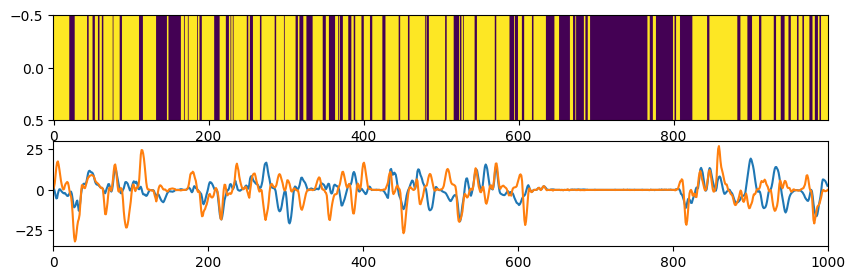

In [45]:
plt.figure(figsize=(10,3))
plt.subplot(2,1,1)
plt.imshow(discrete_latents_slds[None,:1000],aspect='auto')
plt.subplot(2,1,2)
plt.plot(Velocity[:1000])
plt.xlim([0,1000])